In [29]:
import os, sys
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy import linalg as LA
import seaborn as sns

In [2]:
dirpathTrain= "IDENTIFICACION/ORLProcessed/train"
dirpathTest= "IDENTIFICACION/ORLProcessed/test"

# Procesado de datos

In [3]:
def readpgm(name):
    with open(name) as f:
        lines = f.readlines()

    # Ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    # Makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2' 

    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    return (np.array(data[3:]),(data[1],data[0]),data[2])

In [4]:
def getDataSetArray(dirpath):
    images = []
    labels = []
    for usuarioSistema in os.listdir(dirpath):
        try:
            folderPath = os.path.join(dirpath,usuarioSistema)
            for file in os.listdir(folderPath):
                filePath = os.path.join(folderPath,file)
                data = readpgm(filePath)
                images.append(data[0])
                tamañoImagen = data[1]
                labels.append(usuarioSistema)
        except:
            print("Error de lectura %s" % usuarioSistema)
    print("Imagenes procesadas %d total de individuos %d tamañoImagen %s " %(len(images),len(set(labels)),tamañoImagen))
    return np.matrix(images),labels


In [5]:
imagesTrain,labelsTrain = getDataSetArray(dirpathTrain)
imagesTest,labelsTest = getDataSetArray(dirpathTest)

Error de lectura .DS_Store
Imagenes procesadas 200 total de individuos 40 tamañoImagen (112, 92) 
Error de lectura .DS_Store
Imagenes procesadas 200 total de individuos 40 tamañoImagen (112, 92) 


# PCA SKLEARN

In [33]:
results =[]
for pcaComponentes in range(1,200,2):
    pca = PCA(n_components=pcaComponentes)
    newsImagesToTrain = pca.fit_transform(imagesTrain)
    newsImagesToTest = pca.transform(imagesTest)
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(newsImagesToTrain,labelsTrain)
    results.append(clf.score(newsImagesToTest,labelsTest))

Text(0, 0.5, 'accuracy')

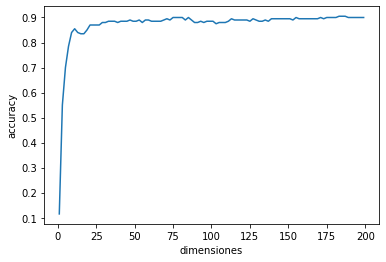

In [40]:
plt.plot(list(range(1,200,2)),results)
plt.xlabel("dimensiones")
plt.ylabel("accuracy")

In [8]:
mejorResultado = max(enumerate(results),key = lambda t:t[1])
print("el mejor resultado obtenido con %d dimensiones es %.3f" %(mejorResultado))

el mejor resultado obtenido con 91 dimensiones es 0.905


# PCA

In [12]:
def calculaPCA(matrix):
    #La matriz entra como nºmuestras * nº dimensiones
    matrix = matrix.T
    print("data matrix %s " %str(matrix.shape))
    d = matrix.shape[0]
    n = matrix.shape[1]
    print("d: %d n: %d" %(d,n))
    media = matrix.mean(axis=1)
    print("media %d " % media.shape[0])
    A = matrix-media
    print("A %s" % str(A.shape))
    C = 1/float(d) * A.T *A
    print("C %s" %str(C.shape))
    DeltaP, Bp = LA.eig(C)
    B = A * Bp 
    print("B %s" %str(B.shape))
    Delta = d / float(n) * DeltaP
    eigenValuesOrdered = sorted(list(enumerate(Delta)),key = lambda t: t[1], reverse=True)
    idx = list(map(lambda t : t[0], eigenValuesOrdered))
    B = B[:,idx]
    return B/LA.norm(B,axis=0)
    

In [13]:
pcaMatrix = calculaPCA(imagesTrain)

data matrix (10304, 200) 
d: 10304 n: 200
media 10304 
A (10304, 200)
C (200, 200)
B (10304, 200)


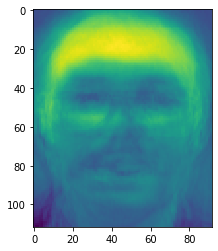

In [14]:
plt.imshow(np.reshape(pcaMatrix[:,0],(112,92)))

In [15]:
def transformaDatos(datos,PCAmatrix,ndimensiones):
    misVectores = PCAmatrix[:,1:ndimensiones+1]
    media = datos.mean(axis=0)
    imagenesResultantes = (datos-media)*misVectores
    
    return imagenesResultantes

In [43]:
trainReducidas = transformaDatos(imagesTrain,pcaMatrix,91)
testReducidas = transformaDatos(imagesTest,pcaMatrix,91)

In [44]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(trainReducidas,labelsTrain)
clf.score(testReducidas,labelsTest)

0.885

In [18]:
values = []
pcaMatrix = calculaPCA(imagesTrain)
for dim in range(1,200,1):
    trainReducidas = transformaDatos(imagesTrain,pcaMatrix,dim)
    testReducidas = transformaDatos(imagesTest,pcaMatrix,dim)
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(trainReducidas,labelsTrain)
    values.append(clf.score(testReducidas,labelsTest))

data matrix (10304, 200) 
d: 10304 n: 200
media 10304 
A (10304, 200)
C (200, 200)
B (10304, 200)


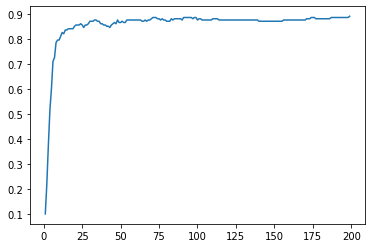

In [19]:
plt.plot(list(range(1,200)),values)

# LDA


In [75]:
import scipy.linalg as scipylg
def calculaLDA(matrix,etiquetas):
    
    print("shape data ",matrix.shape)
    mu = matrix.mean(axis = 1)
    print("shape mu ",mu.shape)
    sb = np.zeros((matrix.shape[0],matrix.shape[0]))
    sw = sb.copy()
    print("sb shape", sb.shape)
    for etiqueta in set(etiquetas):
        labels = np.where(etiquetas == etiqueta)
        matrix_class = matrix[:,labels[0]]
        mu_class = matrix_class.mean(axis = 1)
        #print("shape mu_class ",mu.shape)
        samples_class = matrix_class.shape[1]
        sb += samples_class * (mu_class -mu) *(mu_class-mu).T
        sw += (matrix_class-mu_class) * (matrix_class-mu_class).T
    print("generalized eigen vectors")
    Delta, B = scipylg.eig(sb, sw)
    eigenValuesOrdered = sorted(list(enumerate(Delta)),key = lambda t: t[1], reverse=True)
    idx = list(map(lambda t : t[0], eigenValuesOrdered))
    B = B[:,idx]
    return B

In [76]:
trainReducidas = transformaDatos(imagesTrain,pcaMatrix,200)
testReducidas = transformaDatos(imagesTest,pcaMatrix,200)

In [77]:
matrixLDA = calculaLDA(trainReducidas.T,np.array(labelsTrain))

shape data  (199, 200)
shape mu  (199, 1)
sb shape (199, 199)
generalized eigen vectors


In [72]:
def transformaDatos(datos,matrix,ndimensiones):
    misVectores = matrix[:,1:ndimensiones+1]
    media = datos.mean(axis=0)
    imagenesResultantes = (datos)*misVectores
    
    return imagenesResultantes

In [74]:
values = []
for dimensiones in range(1,39):
    trainReducidas2 = transformaDatos(trainReducidas,matrixLDA,dimensiones)
    testReducidas2 = transformaDatos(testReducidas,matrixLDA,dimensiones)
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(trainReducidas2,labelsTrain)
    values.append(clf.score(testReducidas2,labelsTest))
print(max(enumerate(values),key=lambda t:t[1]))

(32, 0.855)


Text(0, 0.5, 'accuracy')

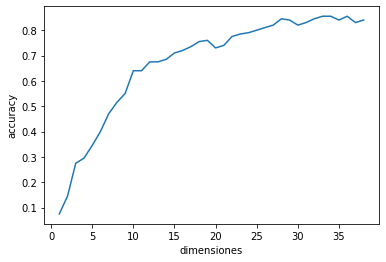

In [69]:
plt.plot(list(range(1,39,1)),values)
plt.xlabel("dimensiones")
plt.ylabel("accuracy")